In [ ]:
!pip install epigenomic_dataset
!pip install ucsc_genomes_downloader
!pip install keras_bed_sequence
!pip install minepy
!pip install boruta
!pip install extra_keras_metrics

  Created wheel for epigenomic-dataset: filename=epigenomic_dataset-1.2.11-py3-none-any.whl size=16125 sha256=c32d6f0911f5e2581cd630876864fe72d24ba35deff71987f56579b05d61509a
  Stored in directory: /root/.cache/pip/wheels/55/ae/00/711945f7eb139c3e7b5afd32628e468070b86698175d938b43
  Created wheel for crr-labels: filename=crr_labels-1.1.1-py3-none-any.whl size=13910 sha256=34d4a153fa5542b4521791e9806524aece153d4a85d297da776f1589a14b8f4d
  Stored in directory: /root/.cache/pip/wheels/11/35/18/9f4c037100da0b7c44bbe85ed0d0e0520d71855f8d92c399c1
  Created wheel for encodeproject: filename=encodeproject-1.0.27-py3-none-any.whl size=9621 sha256=fe1dc351188c73a0ab613cf16da4d4a03acecf4a60d9e76e45f0ccff82adf74f
  Stored in directory: /root/.cache/pip/wheels/74/03/63/a272266e6c9c3d5ce2ccf1088508c952e91b0101650730ce44
  Created wheel for notipy-me: filename=notipy_me-1.3.23-py3-none-any.whl size=11705 sha256=2088df7373329bc1d4aa1acb843490b243d800d7d1ca2784ca1b624f5f9d0b21
  Stored in directory: /r

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from boruta import BorutaPy
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.decomposition import PCA

from tensorflow.keras.layers import Dense, InputLayer, Layer, Conv1D, Reshape, Flatten, MaxPool1D, Dropout, Concatenate, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from extra_keras_metrics import get_standard_binary_metrics

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr
from scipy.stats import entropy
from minepy import MINE

from scipy.stats import wilcoxon
import scipy.stats as st

from typing import Dict
from sanitize_ml_labels import sanitize_ml_labels
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, average_precision_score

from keras_bed_sequence import BedSequence
from keras_mixed_sequence import MixedSequence, VectorSequence

from ucsc_genomes_downloader import Genome
from epigenomic_dataset import load_epigenomes

**Data retrieval**

In [ ]:
# Window_size is the size of the regions considered for the classification.
window_size = 256

In [ ]:
# The value assigned to the variable assembly simply indicate the uman genome. 
assembly="hg38"

# The cell_line indicate the type of the human cell for which the DNA is being considered.
cell_line="GM12878"

In [ ]:
# Import the epigenomes and labels (originaly obtained from ENCODE and FANDOM respectively) for promoters and enanchers.

promoters_epigenomes, promoters_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "promoters",
    window_size = window_size,
    binarize = True
)

enhancers_epigenomes, enhancers_labels = load_epigenomes(
    cell_line = cell_line,
    dataset = "fantom",
    region = "enhancers",
    window_size = window_size,
    binarize = True
)

In [ ]:
# Trasform the boolean labels into integer (false->0,true->1).
promoters_labels['GM12878']=promoters_labels['GM12878'].astype(int)
enhancers_labels['GM12878']=enhancers_labels['GM12878'].astype(int)

In [ ]:
# Examples of promoters epigenomes (features of the BED format more the level of interanction with the given genes).
promoters_epigenomes.head()

chrom                             SMAD5  CEBPZ  MEF2C  ...  E2F4  E4F1  CHD4
chrom chromStart chromEnd strand                       ...                  
chr1  628964     629220   +        0.48   0.52   0.19  ...  0.38  0.78  0.84
      629013     629269   +        0.36   0.52   0.12  ...  0.07  0.91  0.68
      629642     629898   +        0.00   0.00   0.00  ...  0.00  1.63  0.38
      629847     630103   +        0.38   0.00   0.00  ...  0.03  1.80  0.48
      629905     630161   +        0.51   0.00   0.00  ...  0.09  1.43  0.51

[5 rows x 152 columns]

In [ ]:
# Examples of promoters labels from fantom.
promoters_labels.head()

GM12878
chrom chromStart chromEnd strand         
chr1  628964     629220   +             0
      629013     629269   +             0
      629642     629898   +             0
      629847     630103   +             0
      629905     630161   +             0

In [ ]:
# Examples of enhancers epigenomes (features of the BED format more the level of interanction with the given genes).
enhancers_epigenomes.head()

chrom                              SMAD5  CEBPZ  MEF2C  ...  E2F4  E4F1  CHD4
chrom chromStart chromEnd  strand                       ...                  
chr10 100006381  100006637 .        0.80   1.41   1.31  ...  0.89  0.83  0.93
      100008146  100008402 .        0.69   1.37   0.33  ...  0.43  0.74  0.99
      100014418  100014674 .        1.21   1.66   3.00  ...  0.52  0.59  1.56
      100020216  100020472 .        1.16   1.51   0.87  ...  0.72  1.33  1.57
      100043528  100043784 .        0.49   1.13   0.17  ...  1.22  2.02  1.12

[5 rows x 152 columns]

In [ ]:
# Examples of enanchers labels from fantom.
enhancers_labels.head()

GM12878
chrom chromStart chromEnd  strand         
chr10 100006381  100006637 .             0
      100008146  100008402 .             0
      100014418  100014674 .             0
      100020216  100020472 .             0
      100043528  100043784 .             0

In [ ]:
# create two dictionaries, one for the epigenomes, one for the labels.

epigenomes = {
    "promoters": promoters_epigenomes,
    "enhancers": enhancers_epigenomes
}

labels = {
    "promoters": promoters_labels,
    "enhancers": enhancers_labels
}

In [ ]:
# Retrive from the  UCSC Genome Browser the nitrogen basis sequences of the human genome. 

genome = Genome(assembly)

In [ ]:
# Transform the genome in a dataframe where the nitrogen basis sequences are represented throgh one hot encoding.

# Return data in BED format.
def to_bed(data:pd.DataFrame)->pd.DataFrame:
    """Return bed coordinates from given dataset."""
    return data.reset_index()[data.index.names]

# One hot encode the data.
def one_hot_encode(genome:Genome, data:pd.DataFrame, nucleotides:str="actg")->np.ndarray:
    return np.array(BedSequence(
        genome,
        bed=to_bed(data),
        nucleotides=nucleotides,
        batch_size=1
    ))

# Flatten the one hot encode representation.
def flat_one_hot_encode(genome:Genome, data:pd.DataFrame, window_size:int, nucleotides:str="actg")->np.ndarray:
    return one_hot_encode(genome, data, nucleotides).reshape(-1, window_size*4).astype(int)

# Create a dataframe from the data.
def to_dataframe(x:np.ndarray, window_size:int, nucleotides:str="actg")->pd.DataFrame:
    return pd.DataFrame(
        x,
        columns = [
            f"{i}{nucleotide}"
            for i in range(window_size)
            for nucleotide in nucleotides
        ]
    )

# The dataset of the genome sequences will be identifyed by the dictionary sequences.
sequences = {
    region: to_dataframe(
        flat_one_hot_encode(genome, data, window_size),
        window_size
    )
    for region, data in epigenomes.items()
}            

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
# Examples of promoters one hot encoded sequences. 
sequences["promoters"][:5]

,0a,0c,0t,0g,1a,1c,1t,1g,2a,2c,2t,2g,3a,3c,3t,3g,4a,4c,4t,4g,5a,5c,5t,5g,6a,6c,6t,6g,7a,7c,7t,7g,8a,8c,8t,8g,9a,9c,9t,9g,...,246a,246c,246t,246g,247a,247c,247t,247g,248a,248c,248t,248g,249a,249c,249t,249g,250a,250c,250t,250g,251a,251c,251t,251g,252a,252c,252t,252g,253a,253c,253t,253g,254a,254c,254t,254g,255a,255c,255t,255g
0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0
2,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0
3,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1
4,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


In [ ]:
# Examples of enhancers one hot encoded sequences. 
sequences["enhancers"][:5]

,0a,0c,0t,0g,1a,1c,1t,1g,2a,2c,2t,2g,3a,3c,3t,3g,4a,4c,4t,4g,5a,5c,5t,5g,6a,6c,6t,6g,7a,7c,7t,7g,8a,8c,8t,8g,9a,9c,9t,9g,...,246a,246c,246t,246g,247a,247c,247t,247g,248a,248c,248t,248g,249a,249c,249t,249g,250a,250c,250t,250g,251a,251c,251t,251g,252a,252c,252t,252g,253a,253c,253t,253g,254a,254c,254t,254g,255a,255c,255t,255g
0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0
1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0


**Data pre-pocessing**

In [ ]:
# Check the presence of missing values.

for region, data in epigenomes.items():
  print("{} data:".format(region))
  print("Total number of NaN values: {0} over {1}".format(data.isna().values.sum(),data.values.size))
  print("Max number of NaN values per feature: {0} over {1}".format(data.isna().values.sum(axis=0).max(),data.shape[0]))
  print("Max number of NaN values per sample: {0} over {1}".format(data.isna().values.sum(axis=1).max(),data.shape[1]))
  print("\n")

promoters data:
Total number of NaN values: 423 over 15181912
Max number of NaN values per feature: 198 over 99881
Max number of NaN values per sample: 40 over 152


enhancers data:
Total number of NaN values: 62 over 9619320
Max number of NaN values per feature: 56 over 63285
Max number of NaN values per sample: 4 over 152




In [ ]:
# Check the presence of missing values.

for region, data in epigenomes.items():
  print("{} data:".format(region))
  print("Total number of NaN values: {0} over {1}".format(data.isna().values.sum(),data.values.size))
  print("Max number of NaN values per sample: {0} over {1}".format(data.isna().values.sum(axis=0).max(),data.shape[0]))
  print("Max number of NaN values per features: {0} over {1}".format(data.isna().values.sum(axis=1).max(),data.shape[1]))
  print("\n")

promoters data:
Total number of NaN values: 423 over 15181912
Max number of NaN values per sample: 198 over 99881
Max number of NaN values per features: 40 over 152


enhancers data:
Total number of NaN values: 62 over 9619320
Max number of NaN values per sample: 56 over 63285
Max number of NaN values per features: 4 over 152




In [ ]:
# Impute the missing data with the k-NN imputer (k=5).
# In other words, assign to each missing feature value for a given sample, the same feature value of the most "similar" sample.

imputer = KNNImputer()

for region, data in epigenomes.items():
  # Tranform the result of the imputer in a dataframe with the same columns and rows of the one in input.
  epigenomes[region]=pd.DataFrame(imputer.fit_transform(data),columns=data.columns,index=data.index)

In [ ]:
# Drop the samples with more than 30 NaN values.
for region, data in epigenomes.items():
  index=data.isna().values.sum(axis=1)
  index=[i for i in range(0,len(index)) if index[i]>30]
  for i in reversed(index):
    epigenomes[region]=data.drop(data.index[i])
    labels[region]=labels[region].drop(labels[region].index[i])
    sequences[region]=sequences[region].drop(sequences[region].index[i])

In [ ]:
# There should not be missing values anymore.

for region, data in epigenomes.items():
  print("{} data:".format(region))
  if (data.isna().values.any()):
    print("missing values are still presents")
  else:
    print("there are no more missing values")
  print("\n")

promoters data:
there are no more missing values


enhancers data:
there are no more missing values




In [ ]:
# normalization of the data throgh robust scaler, a version of the scaler konwn as z-score.

scaler=RobustScaler()

for region, data in epigenomes.items():
  # Tranform the result of the scaler in a dataframe with the same columns and rows of the one in input.
  epigenomes[region]=pd.DataFrame(scaler.fit_transform(data),columns=data.columns,index=data.index)

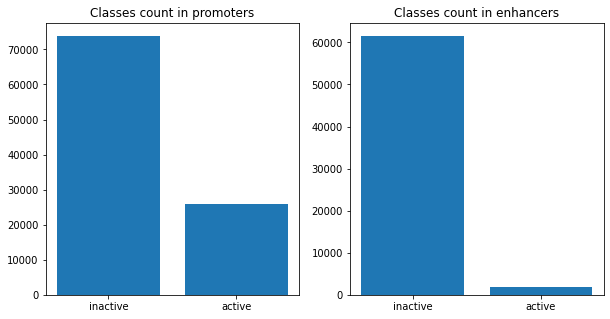

In [ ]:
# Obtain a visual representation of the possible imbalance of the data throgh the distribution of active and inactive samples.

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
classes=['inactive','active']
i=0

for region, label in labels.items():
  ax[i].set_title('Classes count in {}'.format(region))
  count_samples=[len(label[(label['GM12878']==0)]),len(label[(label['GM12878']==1)])]
  ax[i].bar(classes,count_samples)
  i=i+1
fig.show()

In [ ]:
# Print the two ratios between active and inactive samples.

for region, label in labels.items():
  active_count=len(label[(label['GM12878']==1)])
  inactive_count=len(label[(label['GM12878']==0)])

  count_sum=active_count+inactive_count

  active_ratio=active_count/active_count
  inactive_ratio=inactive_count/active_count
  print('ratio between active/inactive for {0} is: {1}/{2}'.format(region, active_ratio, inactive_ratio))

ratio between active/inactive for promoters is: 1.0/2.836412521605531
ratio between active/inactive for enhancers is: 1.0/35.26647564469914


**Correlation**

In [ ]:
# p-values and correlations thresholds.

p_value_threshold = 0.01
correlation_threshold = 0.05

In [ ]:
# Create the sets of features uncorrelated whit the output for both the enhanchers and the promoters.
# Initialy this sets will be empty, features will be added after the tests.

uncorrelated = {}

for region, _ in epigenomes.items():
  uncorrelated[region] = set()

In [ ]:
# Compute the Spearman correlation between the features and their outputs to find out if they are not correlated according to a monotonic function.
# Add the uncorrelated features to the set of the region in the dictionary uncurrelated.

for region, data in epigenomes.items():
  for column in data.columns:
    correlation, p_value = spearmanr(data[column].values.ravel(), labels[region].values.ravel())
    if p_value > p_value_threshold and correlation < correlation_threshold:
      print("For the {0} feature {1} dosen't seem to be correlated to the output, correlation: {2}".format(region,column,correlation))
      uncorrelated[region].add(column)

For the enhancers feature NFYA dosen't seem to be correlated to the output, correlation: 0.0035538192219031236


In [ ]:
# Compute the Maximal information coefficient to confirm that the feature previusly identified as uncurrelated to the output.
# This test check both linear and non-linear correlation.

for region, data in epigenomes.items():
  for column in uncorrelated[region]:
    mine = MINE()
    mine.compute_score(data[column].values.ravel(), labels[region].values.ravel())
    computed_score=mine.mic()
    if computed_score < correlation_threshold:
      print("For the {0} feature {1} dosen't seem to be correlated to the output, correlation: {2}".format(region,column,computed_score))
    else:
        uncorrelated[region].remove(column)
        print("For the {0} feature {1} seem to be correlated to the output, correlation: {2}".format(region,column,computed_score))
        print("Removing the feature from the set of features uncorrelated with the output")


For the enhancers feature NFYA dosen't seem to be correlated to the output, correlation: 0.009955576156008636


In [ ]:
# Remove features which are not correlated to the output.

for region, data in epigenomes.items():
  columns_to_drop=[]
  for column in uncorrelated[region]:
    columns_to_drop.append(column) 
  epigenomes[region]=data.drop(columns=columns_to_drop)    


In [ ]:
# Print number of columns in the two datasets.
for region, data in epigenomes.items():
  print('Number of features in {0}: {1}'.format(region,len(data.columns)))

Number of features in promoters: 152
Number of features in enhancers: 151


In [ ]:
# redefine p-values and correlations thresholds (p-values stays the same).

#p_value_threshold = 0.01
correlation_threshold = 0.95

In [ ]:
# Create the sets of features uncorrelated with each others for both the enhanchers and the promoters.
# Initialy this sets will be empty, features will be added after the tests.

extremely_correlated = {}

for region, data in epigenomes.items():
  extremely_correlated[region]= set()

In [ ]:
# Correlation scores will be stored in a dictionary of array of tuples (correlation score,first feature,second feature).

correlation_scores={}

for region,data in epigenomes.items():
  correlation_scores[region]= []

In [ ]:
# Compute the correlation scores.

for region, data in epigenomes.items():
  columns_names=data.columns
  for i in range(0,data.shape[1]):
    for j in range(i+1,data.shape[1]):
       correlation, p_value = spearmanr(data[columns_names[i]].values.ravel(), data[columns_names[j]].values.ravel())
       # Correlation absolute value.
       correlation = np.abs(correlation)
       correlation_scores[region].append((correlation,columns_names[i],columns_names[j]))
       if p_value < p_value_threshold and correlation > correlation_threshold:
                print("For {0} feature {1} and feature {2} seems to be highly correlated, correlation: {3} ".format(region, columns_names[i], columns_names[j], correlation))
                # If the two feature are highly correlated, add to the list of highly correlated features the one of the two with the lower entropy.
                if entropy(data[columns_names[i]]) > entropy(data[columns_names[i]]):
                    extremely_correlated[region].add(columns_names[j])
                else:
                    extremely_correlated[region].add(columns_names[i])

In [ ]:
# Sort the correlation scores of all the pair of feature by the correlation score associated.

for region, scores in correlation_scores.items():
  correlation_scores[region]=sorted(correlation_scores[region], key=lambda x: (x[0]), reverse=True)

Most correlated features form promoters scatterplot:


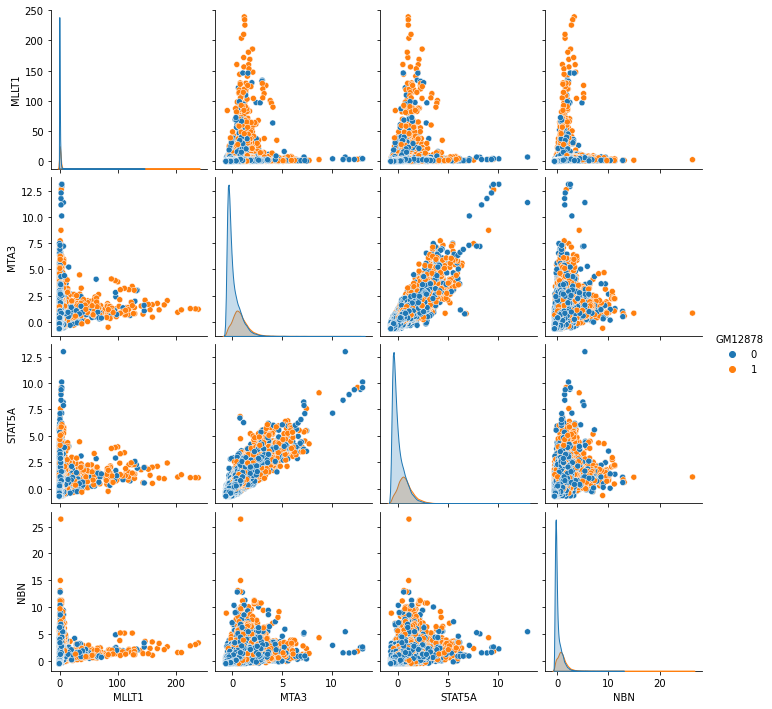

Most correlated features form enhancers scatterplot:


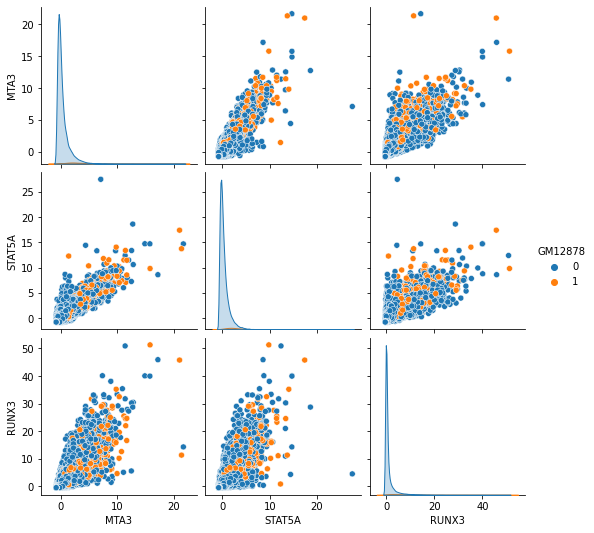

In [ ]:
# Plot the scatterplot for the features which correlation with another feature is among the highest 3 measured.

for region, data in epigenomes.items():
  first_features=[x[1] for x in correlation_scores[region][:2]]
  second_features=[x[2] for x in correlation_scores[region][:2]]
  columns=list(set(first_features+second_features))
  print("Most correlated features form {} scatterplot:".format(region))
  sns.pairplot(pd.concat([data[columns],labels[region]], axis=1), hue=labels[region].columns[0])
  plt.show()

Most correlated features form promoters scatterplot:


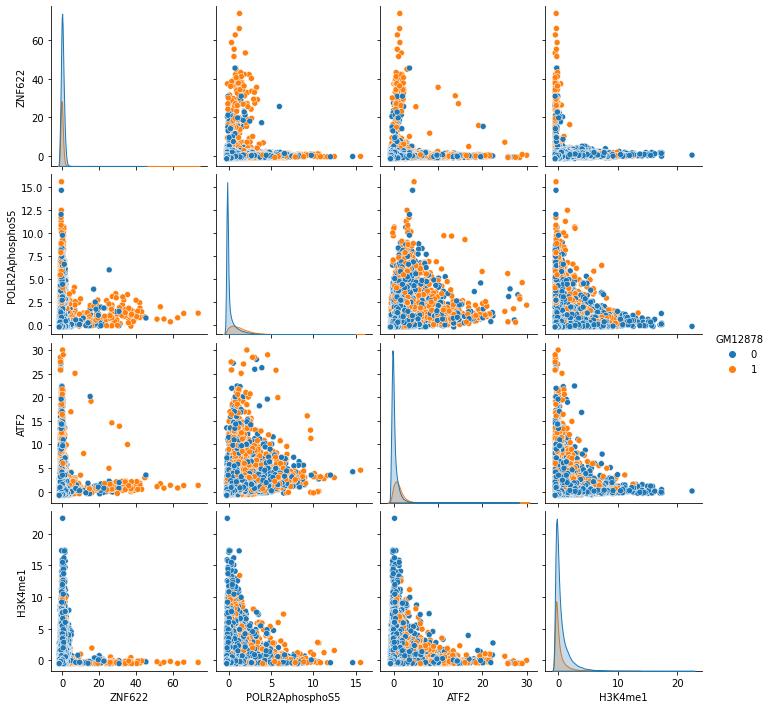

Most correlated features form enhancers scatterplot:


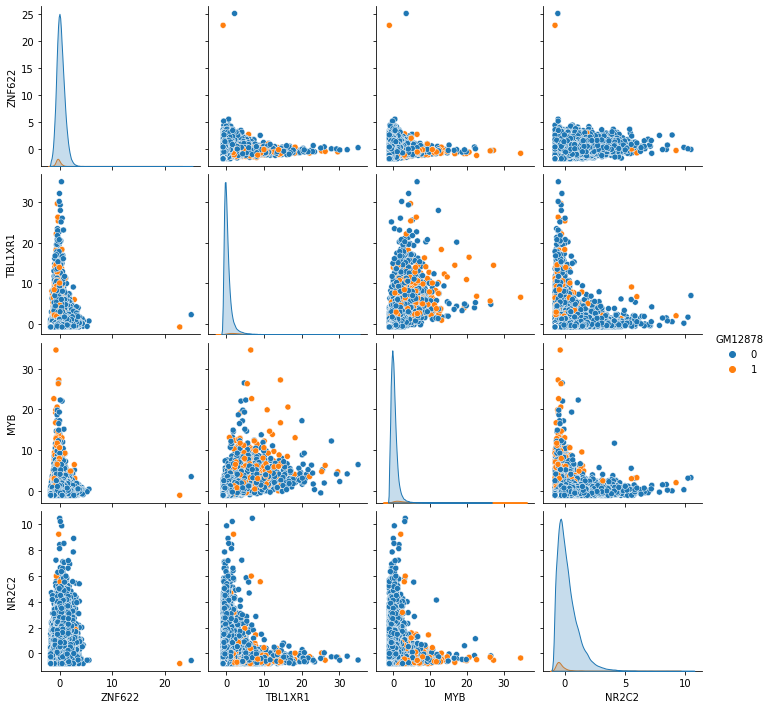

In [ ]:
# Plot the scatterplot for the features which correlation with another feature is among the lowest 3 measured.

for region, data in epigenomes.items():
  first_features=[x[1] for x in correlation_scores[region][-2:]]
  second_features=[x[2] for x in correlation_scores[region][-2:]]
  columns=list(set(first_features+second_features))
  print("Most correlated features form {} scatterplot:".format(region))
  sns.pairplot(pd.concat([data[columns],labels[region]], axis=1), hue=labels[region].columns[0])
  plt.show()

**Distribution**

In [ ]:
# Number of the most different columns tath are considered (euclidean distance).
number_considered=4

# Compute  the mean of the distances for each column and returns the last number_column_to_consider.
def sorted_columns_indices(matrix, number_column_to_consider):
  return np.argsort(np.mean(matrix,axis=1).flatten())[-number_column_to_consider:]

4 most different features distributions for promoters


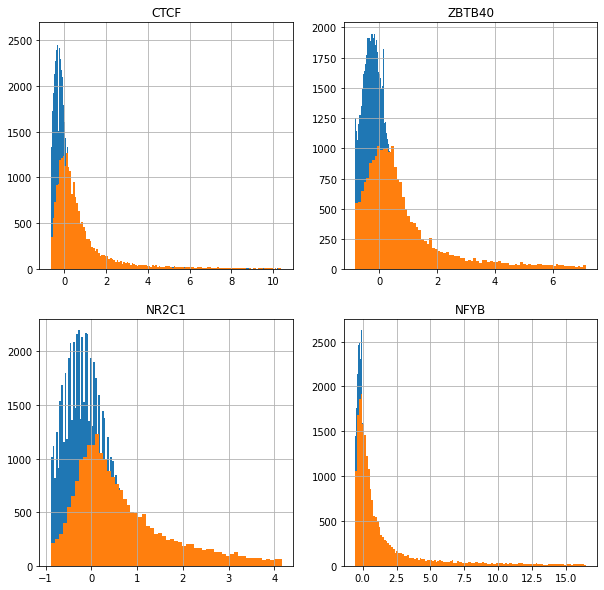

4 most different features distributions for enhancers


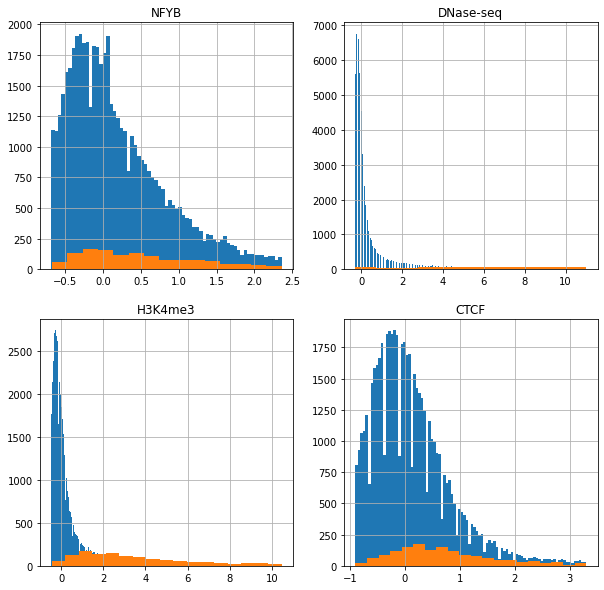

In [ ]:
# Plot the distribution of the 4 more different features trogh histograms.
for region, data in epigenomes.items():
  distances_matrix=euclidean_distances(data.T)
  most_distant_columns_indices=sorted_columns_indices(distances_matrix,number_considered)
  columns=data.columns[most_distant_columns_indices]
  fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
  print("4 most different features distributions for {}".format(region))

  for column,axis in zip(columns,axes.flatten()):
    axis.set_title(column)

    # Remove outliers.
    head, tail = data[column].quantile([0.05, 0.95]).values.ravel()

    mask = ((data[column] < tail) & (data[column] > head)).values

    cleared_x = data[column][mask]
    cleared_y = labels[region].values.ravel()[mask]

    # Draw the histograms.
    cleared_x[cleared_y==0].hist(ax=axis,bins='auto')
    cleared_x[cleared_y==1].hist(ax=axis,bins='auto')
  plt.show()  

**Feature selection with Boruta.**

In [ ]:
# Boruta use a random forest classifier inside its procedure.
# This classifier is here defined as random_forest_classifier.
random_forest_classifier=RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)

# The function recive a dataset and its labels and return the classifier filtered.
def boruta_feature_selection(X:pd.DataFrame,y:pd.DataFrame)->BorutaPy:
  
  # alpha is the p-value that will be used to reject of accept the features.
  boruta_feature_selector=BorutaPy(random_forest_classifier,n_estimators='auto',verbose=2,alpha=0.05,max_iter=10,random_state=1)

  boruta_feature_selector.fit(X.values, y.values.ravel())
  
  return boruta_feature_selector.transform(X.values)

In [ ]:
filtered_epigenomes={}

for region, data in epigenomes.items():
  filtered_epigenomes[region]=boruta_feature_selection(data,labels[region])

Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	152
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	152
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	152
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	152
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	152
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentative: 	152
Rejected: 	0
Iteration: 	7 / 10
Confirmed: 	0
Tentative: 	152
Rejected: 	0
Iteration: 	8 / 10
Confirmed: 	149
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 10
Confirmed: 	149
Tentative: 	3
Rejected: 	0


BorutaPy finished running.

Iteration: 	10 / 10
Confirmed: 	149
Tentative: 	3
Rejected: 	0
Iteration: 	1 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	2 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	3 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	4 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	5 / 10
Confirmed: 	0
Tentative: 	151
Rejected: 	0
Iteration: 	6 / 10
Confirmed: 	0
Tentat

**Data visualization and dimensionality reduction**

In [ ]:
# Definition of a function which perform the PCA to reduce the data in a space of dimension equal to n_selected_components (default=2).
def pca(x:np.ndarray, n_selected_components:int=2):
  return PCA(n_components=n_selected_components).fit_transform(x)

In [ ]:
# Prepare the data to plot them into scatterplots.

# Collect the values form the epigenomes and sequences dictionaries, separating promoters form encoders.
input_type=[ 
            *[value.values for value in epigenomes.values()],
            *[value.values for value in sequences.values()],
]
# Collect twice (one for epigenomes one for sequences) the labels values form the epigenome dictionary, separating promoters form encoders.
output_type=[
             *[val.values.ravel() for val in labels.values()],
             *[val.values.ravel() for val in labels.values()],
]

# Define plots titles.
titles=[
        "Epigenomes promoters",
        "Epigenomes enhancers",
        "Sequences promoters",
        "Sequences enhancers"
]

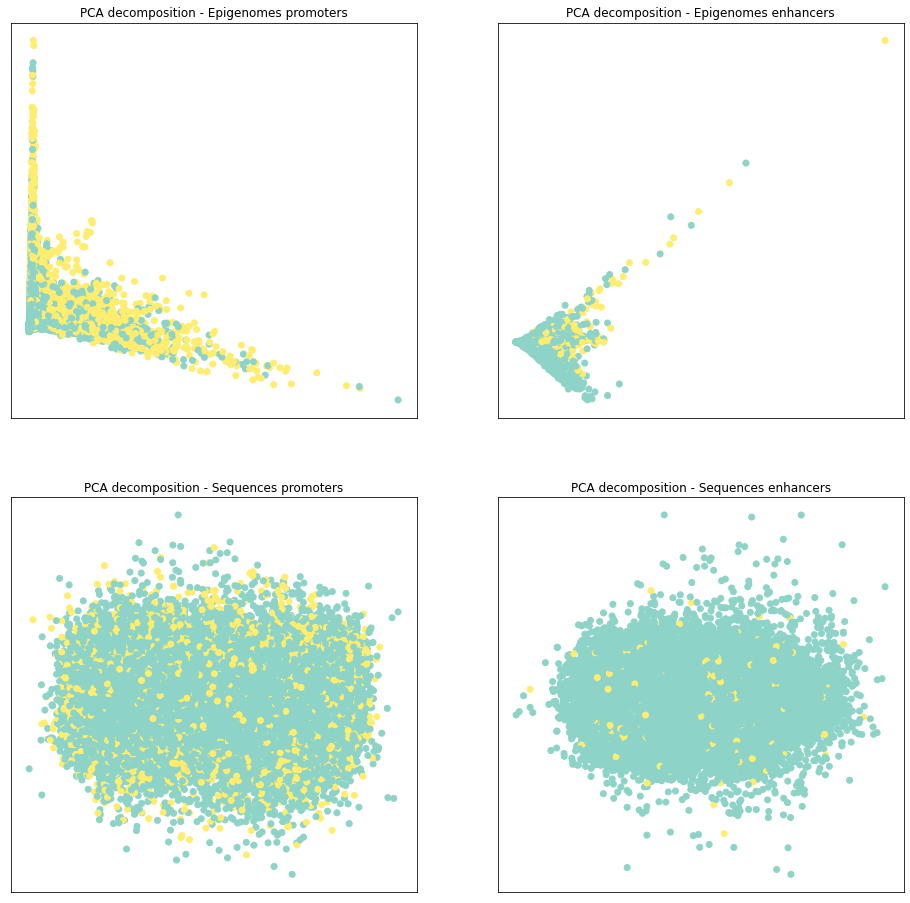

In [ ]:
# For each of the 4 grop of data in the previous cell, plot the graphs of the 2 principal components obtained throgh PCA.
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

for X, y, title, axis in zip(input_type, output_type, titles, axes.flatten()):
    axis.scatter(*(pca(X).T),c=y,cmap='Set3')
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.set_title("PCA decomposition - {}".format(title))
plt.show()